<a href="https://colab.research.google.com/github/matteoalberti/Lectures_AdvCV_Experis2020/blob/main/day1/DL4CV_2_Architecture_Module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://github.com/matteoalberti/Lectures_introCV_Experis2020/blob/main/images/intro.jpg?raw=1)

# **Welcome!**

## Introduction to Machine Learning for Computer Vision



## **Lecturer :** Matteo Alberti

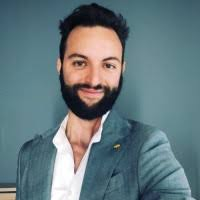

*Contacts :* https://www.linkedin.com/in/matteo-alberti-170493/


# Summary


- <font color=C24024>**Best Practices & Basic Architecture** </font> : [LeNet]

- <font color=CA4A2F>**Train a Convolutional Networks with Keras** </font> : 

    - <font color=E35F2A>**Work with Model** </font>

    - <font color=EF8932>**Work with data** </font> : [Visualize inside CNN]

- <font color=F4C52D>**Exercises & Tips** </font>

#### Load Packages

In [ ]:
import os
import pickle
import pandas as pd
import argparse
import time
import gc
import datetime
import platform
import numpy as np
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 

#Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

try:
    import pydot_ng as pydot
except ImportError:
    pydot = None
    
try:
    os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
except:
    pass

#Sklearn ML
from sklearn.model_selection import train_test_split
from skimage.transform import resize

#Keras Imports

import tensorflow as tf
import sklearn.model_selection as model_selection


import warnings
warnings.filterwarnings("ignore")

print('TF Version : ',tf.__version__)
print('Python Version : ', platform.python_version())

TF Version :  2.3.0
Python Version :  3.6.9


### Load Cifar10 dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


![](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/07/Depiction-of-CNN-Model-for-Accelerompter-Data.png)

##### Normalize data

In [ ]:
#The range for each individual colour is 0-255
x_train = x_train.astype('float32')/255 
x_test = x_test.astype('float32')/255

### Define HyperParameters & CNN Architecture
   

In [ ]:
#Parameters
import sys;import argparse; sys.argv=['']; del sys
parser = argparse.ArgumentParser(description="CNN")
parser.add_argument('--epochs', default=20, type=int)
parser.add_argument('--iter', default=100, type=int)
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--lr', default=0.001, type=float)

#For VGG
parser.add_argument('--weight_decay', default=0.0001, type=float)
parser.add_argument('--dropout', default=0.5, type=float)


parser.add_argument('--height', default=32, type=int)
parser.add_argument('--width', default=32, type=int)
parser.add_argument('--channel', default=3, type=int)
parser.add_argument('--classes', default=10, type=int)

#FOR RESNET
parser.add_argument('--stack_n', type=int, default=25, metavar='NUMBER',
                help='stack number n, total layers = 6 * n + 2 (default: 5)')

parser.add_argument('--train', default=False)
args = parser.parse_args()

layers_res = 6 * args.stack_n + 2
parser.add_argument('--layers_res', default=layers_res)

#Extras
parser.add_argument('--early_stop', default=3)


args = parser.parse_args()

print(args)

Namespace(batch_size=128, channel=3, classes=10, dropout=0.5, early_stop=3, epochs=20, height=32, iter=100, layers_res=152, lr=0.001, stack_n=25, train=False, weight_decay=0.0001, width=32)


### Baseline Convolutional architecture in Keras : [LeNet]


![](https://irenelizihui.files.wordpress.com/2016/03/tf43.png)

***Commented VERSION***


In [ ]:
def build_Lenet(height,width,channel,classes):
    
    model = tf.keras.Sequential()
    
    #Features Extractor
    model.add(tf.keras.layers.Conv2D(6, (5, 5), 
                     padding='valid', 
                     activation = 'relu', 
                     kernel_initializer='he_normal', #https://keras.io/initializers/#randomnormal
                     input_shape=(height,width,channel)))
    
    """    
    **Valid** -> without padding
    
    inputs:         1  2  3  4  5  6  7  8  9  10 11 (12 13)
                      |________________|                dropped
                                     |_________________|
                                     
   **Same** -> with zero padding
   
                pad|                                      |pad
   inputs:      0 |1  2  3  4  5  6  7  8  9  10 11 12 13|0  0
               |________________|
                              |_________________|
                                             |________________|
                                     
    """
    
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(tf.keras.layers.Conv2D(16, (5, 5), padding='valid', 
                     activation = 'relu', 
                     kernel_initializer='he_normal'))
    
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(tf.keras.layers.Flatten()) # unrolls the values beginning at the last dimension
    
    """
    We need to convert the output of the convolutional part of the CNN 
    into a 1D feature vector during the classification part
    
    It gets the output of the convolutional layers, 
    flattens all its structure to create a single long 
    feature vector to be used by the dense layer 
    for the final classification
    """
    
    
    
    #Classification
    model.add(tf.keras.layers.Dense(120, activation = 'relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Dense(84, activation = 'relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Dense(classes, activation = 'softmax', 
                    kernel_initializer='he_normal'))
    
    #Compile & Optimizers
    sgd = tf.keras.optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=sgd, metrics=['accuracy'])
    
    model.summary()
    return model

***Summary***

In [ ]:
def build_Lenet(height,width,channel,classes):
    
    return tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(6, (5, 5), 
                     padding='valid', 
                     activation = 'relu', 
                     kernel_initializer='he_normal',
                     input_shape=(height,width,channel)),

     
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), padding='valid', 
                     activation = 'relu', 
                     kernel_initializer='he_normal'),
    
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(120, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(84, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(classes, activation = 'softmax', 
                    kernel_initializer='he_normal')])

#### Extra Notes:

    - Why do we need activation function on convolutions?

The purpose of activation functions is mainly to add non-linearity to the network, which otherwise would be only a linear model. A convolutional layer by itself is linear exactly like the fully connected layer.

In fact if you visualize each pixel of the input and output images as a node, then you would obtain a fully connected layer with a lot less edges. Or, in other words, the input values get multiplied by coefficients. Following a complex logic, but nothing more.

In [ ]:
# build network
lenet_base = build_Lenet(height=args.height, 
                         width=args.width, 
                         channel=args.channel, 
                         classes=args.classes)

lenet_base.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

lenet_base.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_13 (Dense)             (None, 84)               

### We can use also the following code to provide a beautiful representation of our architecture

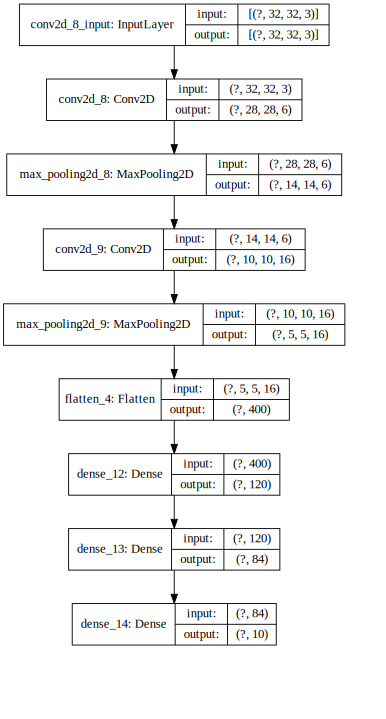

In [ ]:
SVG(model_to_dot(lenet_base, show_shapes=True, 
             show_layer_names=True, 
             rankdir='TB', dpi=65 ).create(prog='dot', 
                                  format='svg'))

### What we need for training

In [ ]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Start training

In [ ]:
# start train
history_lenet = lenet_base.fit(x=x_train, 
          y=y_train, 
          epochs=50,
          validation_split=0.2, 
          callbacks=[tensorboard_callback], verbose=1)

# save model
#lenet_base.save('./pretrained_model/lenet25.h5')

Epoch 1/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.7335 - accuracy: 0.7397 - val_loss: 1.1922 - val_accuracy: 0.6137
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6927 - accuracy: 0.7539 - val_loss: 1.2238 - val_accuracy: 0.6089
Epoch 3/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6650 - accuracy: 0.7663 - val_loss: 1.2251 - val_accuracy: 0.6163
Epoch 4/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6312 - accuracy: 0.7759 - val_loss: 1.3123 - val_accuracy: 0.5992
Epoch 5/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6019 - accuracy: 0.7878 - val_loss: 1.3240 - val_accuracy: 0.6093
Epoch 6/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5729 - accuracy: 0.7973 - val_loss: 1.3904 - val_accuracy: 0.5960
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 0.5502 - accuracy: 0.8060 - val_loss: 1.4540 - val_accuracy:

##### Save and Load Model Weights

In [ ]:
#lenet_base.save_weights('./pretrained_model/lenet25.h5')
#lenet_base.load_weights('./pretrained_model/lenet25.h5')

### Evaluate Prediction & plots

In [ ]:
score = lenet_base.evaluate(x_test, y_test, verbose=0)

In [ ]:
print(score)

[4.42919921875, 0.5764999985694885]


In [ ]:
print(score[0], ' : loss')
print(score[1]*100, '% : acc')

4.42919921875  : loss
57.64999985694885 % : acc


### What is happening?


**Multi Class Classification though Softmax function** 

- *Softmax is a generalization of the sigmoid function.*

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/bdc1f8eaa8064d15893f1ba6426f20ff8e7149c5)


*Steps :*

- Raise e (the mathematical constant) to the power of each of those numbers.
- Sum up all the exponentials (powers of ee). This result is the denominator.
- Use each number’s exponential as its numerator.
- $Probability=\frac{Numerator}{Denominator}$


The softmax function squashes all values to the range [0,1] and the sum of the elements is 1.


*Example* : 

Given : -1, 0, 3, 5

*We calculate Denominator :* $e^{-1}+e^{0} + e^{3} + e^{5}$ = 169.87

*We calculate each Numerator $e^{x}$: * $e^{-1}=0.368, e^{}=1 . . . $

*We calculate single probabilities* $ P(\frac{e^{x}}{Denominator}) $ : $0.368/169.87 = 0.002, 1/169.87= 0.006 . . 

**Bigger x : bigger Probability**

*Try to calculate all values probabilities and sum each other, what is the final number?*



### Any other idea??

In [ ]:
from sklearn.metrics import classification_report

y_pred1 = lenet_base.predict(x_test)
print(classification_report(y_test, y_pred1))

## Graphical Evaluation

#### First Way!

In [ ]:
%tensorboard --logdir logs/fit

```
A brief overview of the dashboards shown (tabs in top navigation bar):
```
- The **Scalars** dashboard shows how the loss and metrics change with every epoch. You can use it to also track training speed, learning rate, and other scalar values.

- The **Graphs** dashboard helps you visualize your model. In this case, the Keras graph of layers is shown which can help you ensure it is built correctly.

- The **Distributions** and Histograms dashboards show the distribution of a Tensor over time. This can be useful to visualize weights and biases and verify that they are changing in an expected way.


Additional TensorBoard plugins are automatically enabled when you log other types of data. For example, the Keras TensorBoard callback lets you log images and embeddings as well. You can see what other plugins are available in TensorBoard by clicking on the "inactive" dropdown towards the top right.


#### Second Way!

In [ ]:
def SHOWPREDICTION(orig, model):
    import matplotlib.pyplot as plt
    
    try:
        img_class = model.predict_classes(orig[:5])
    except AttributeError:
        y_pred1 = model.predict(orig[:5])
        img_class = np.argmax(y_pred1,axis=1)
        
    plt.figure(figsize=(10, 8))

    for i in range(5):
        # display original
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        label_name = load_label_names()
        plt.title(label_name[i])

    plt.show()
  
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Actual label: airplane
Input image shape: (1, 32, 32, 3)
Predict Label: automobile

Predict Probability:
 [[4.4203912e-07 9.1619390e-01 5.9426557e-09 1.2778865e-08 2.5308685e-16
  5.4673971e-10 1.0887791e-08 1.6841312e-13 5.1451865e-09 8.3805658e-02]]


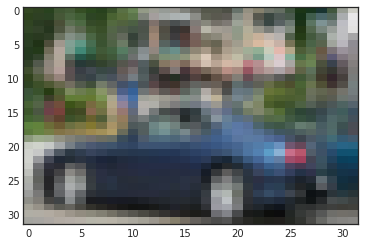

In [ ]:
labelNames = np.array(load_label_names())

# How CNN Classifies an Image?
img_idx = 122
plt.imshow(x_test[img_idx],aspect='auto')
print('Actual label:', labelNames[np.argmax(y_test[img_idx])])
# Preper image to predict
test_image =np.expand_dims(x_test[img_idx], axis=0)
print('Input image shape:',test_image.shape)
print('Predict Label:',labelNames[lenet_base.predict_classes(test_image,batch_size=1)[0]])
print('\nPredict Probability:\n', lenet_base.predict_proba(test_image,batch_size=1))

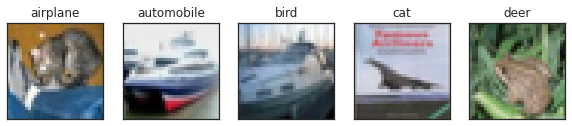

In [ ]:
SHOWPREDICTION(x_test, model=lenet_base)

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
# ---> TRAINED WITH 50 epochs <----
plot_model_history(history_lenet)

## How appears our training history?

![](https://miro.medium.com/max/1125/1*_7OPgojau8hkiPUiHoGK_w.png)

    First of all.. train a lot of time..
    
    But, this isn't enought!

In [ ]:
# ---> TRAINED WITH 50 epochs <----
plot_model_history(history_lenet)

![](https://github.com/matteoalberti/Lectures_introCV_Experis2020/blob/main/images/lenet_50.png?raw=1)

##### But adding epochs doesn't resolve everything.. how can we improve performances?
    
    Two possible ways:
    - work with model (An example : Dropout)
    - work with data  (An example : Data Augmentation)

## Improve Model performances

![](https://d3i71xaburhd42.cloudfront.net/fd66fae4891a7993a66ca98fcdc8ce2207bee8b8/4-Figure2-1.png)

#### Exercise :

- play with LeNet
    - Change hyperparameters, optimizers, receipt fiels and evaluate the performance.
    - *Keep your best model. We'll use it later :)*
    
Sometime you will have to debug.. remember : debugging neural networks isn't like debugging "standard" code. Most of the time *the solution is hidden behind theory*



In [ ]:
def build_Lenet_test(height,width,channel,dropout,classes):
    
    return tf.keras.models.Sequential([])
    
    """
    --> Keep fixed other hyperparameters. 
        You need to be able to compare this architectures
        (but later this will not properly manteined)
    
    
    ----> try not to look above <----
    
    1) try different epochs / batch size - are there any kind of limits?
    2) try different optimizers - evaluate how fast converge
    
    ... 
    
    3) try to change the receipt field (pay attention!)
    
    
    """


# build network
lenet_test = build_Lenet_test(height=args.height, width=args.width, 
                          channel=args.channel,
                          classes=args.classes)


### [Work with Model] Define Dropout

![](https://miro.medium.com/max/1044/1*iWQzxhVlvadk6VAJjsgXgg.png)

Dropout is a regularization technique for deep neural
networks, where it follows the Bernoulli distribution to decide
which node to keep or drop.
- Different DNNs can be obtained by using dropout for every layer
during training as well as testing, and it has been shown that they
are mathematically equivalent to samples from a BDNNs.

**Pros :**
‒ It is easy to turn an existing deep net into a Bayesian one. it is faster than
other techniques, and does not require an inference framework.

**Cons :**
‒ Sampling at test time might be too expensive for computationally‐
demanding (eg real time) applications.

![](https://github.com/matteoalberti/Lectures_introCV_Experis2020/blob/main/images/dropout2.png?raw=1)


#### Develop New Model

In [ ]:
# Choose your best architecture and retrain with a Dropout!

def build_Lenet_dp(height,width,channel,dropout,classes):
    
    return tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(6, (5, 5), 
                     padding='valid', 
                     activation = 'relu', 
                     kernel_initializer='he_normal',
                     input_shape=(height,width,channel)),

    # DROPOUT 
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(16, (5, 5), padding='valid', 
                     activation = 'relu', 
                     kernel_initializer='he_normal'),
    
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(120, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(84, activation = 'relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(classes, activation = 'softmax', 
                    kernel_initializer='he_normal')])
    



# build network
lenet_dp = build_Lenet_dp(height=args.height, width=args.width, 
                          channel=args.channel, dropout=args.dropout,
                          classes=args.classes)

In [ ]:
# COMPILE


# TRAIN


# EVALUATE

*Any improvments?*

- accuracy :
- loss :
- time to execution :

### [Work with Data] Develop data augmentation

<div>
<img src="https://paperswithcode.com/media/tasks/rsz_screenshot_2019-11-29_at_122132_S80u6gv.png" width="500"/>

<img src="https://miro.medium.com/max/732/1*WboGzP5KP12n0hdPRN0JsQ.png" width="500"/>

</div>


Pay attention with Data Augmentation:

- Need some extra time

### Set-up Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


RuntimeError: ignored

In [ ]:
# set up image augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )

datagen.fit(x_train)

In [ ]:
# see example augmentation images
plt.figure(figsize=(6, 6))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

NameError: ignored

<Figure size 432x432 with 0 Axes>

## Retrain our best model with [DA]

In [ ]:
# start train 
history_lenet_dp_da = lenet_base.fit_generator(datagen.flow(x_train, y_train,batch_size=args.batch_size),
                    steps_per_epoch=args.iter,
                    epochs=args.epochs*2,
                    callbacks=cbks,
                    validation_data=(x_test, y_test), verbose=0)

In [ ]:
labelNames = np.array(load_label_names())

# How CNN Classifies an Image?
img_idx = 122
plt.imshow(x_test[img_idx],aspect='auto')
print('Actual label:', labelNames[np.argmax(y_test[img_idx])])
# Preper image to predict
test_image =np.expand_dims(x_test[img_idx], axis=0)
print('Input image shape:',test_image.shape)
print('Predict Label:',labelNames[lenet_dp.predict_classes(test_image,batch_size=1)[0]])
print('\nPredict Probability:\n', lenet_dp.predict_proba(test_image,batch_size=1))

In [ ]:
plot_model_history(history_lenet_dp)

## *Try with lenet + dropout + data augmentation!!*

- Accuracy :
- Loss :
- Time :

- Plot!

## Wanna see an interactive session during training? 

*Check this link!*

https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html